In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pylab import rcParams
from statsmodels.tsa.stattools import acf
random.seed(9001)

In [2]:
sns.set()
plt.style.use('ggplot')
%matplotlib inline
rcParams['figure.figsize'] = 12,8
rcParams['figure.titlesize'] = 15
rcParams['font.size'] = 15
palette = sns.color_palette('mako')

In [3]:
months = ['month_' + str(month) for month in range(1,13)]
mean_temperature = ['yearly_mean']
column_names = months + mean_temperature

In [6]:
df = pd.read_csv('E:/Projects/teste_de_hipotese_Boostrapping/data/stockholm_monthly_mean_temperature_1756_2020_adjust.csv',
                 usecols =['year','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','son']).set_index('year')
df.columns = column_names

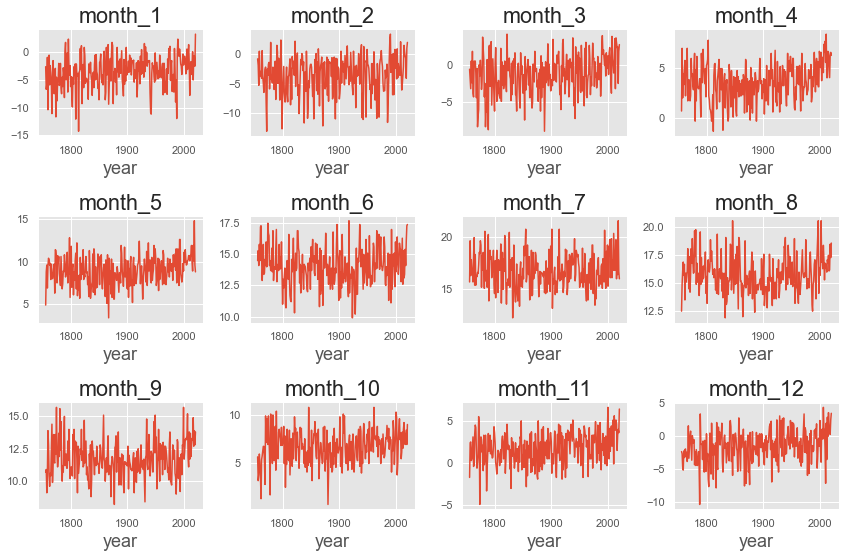

In [7]:
_, axs = plt.subplots(3,4)
axs = axs.ravel()
for i,month in enumerate(months):
  df[month].plot(ax=axs[i], title= month)
  plt.tight_layout();

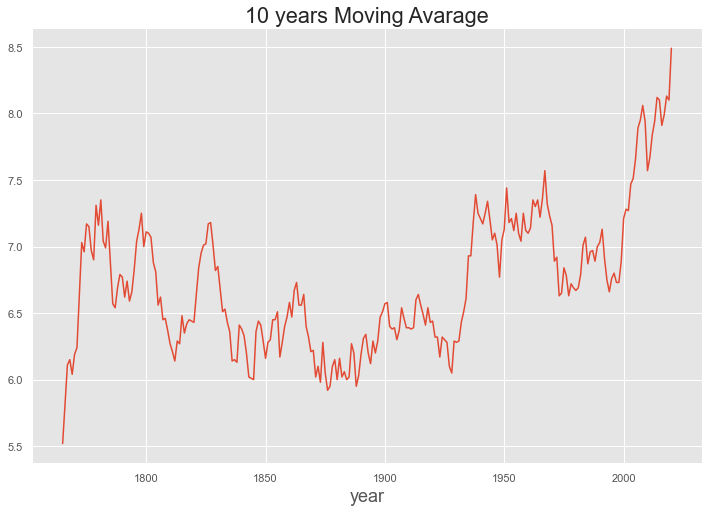

In [9]:
df['yearly_mean'].rolling(window=10, min_periods=10).mean().plot().set_title('10 years Moving Avarage');

In [14]:
df['Epoc'] = df.index.map(lambda x: 'Before 1900s' if x < 1900 else 'After 1900s')
df['century'] = df.index // 100 + 1

In [15]:
df.sample(3)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,yearly_mean,Epoc,century
year,,,,,,,,,,,,,,,
1999,-2.3,-2.4,0.7,6.6,8.9,16.0,19.2,16.4,15.7,7.8,4.3,-1.6,9.3,After 1900s,20
1843,-0.5,-3.3,-2.1,1.1,6.1,12.2,16.4,18.4,11.8,4.0,2.0,1.4,5.9,Before 1900s,19
1797,-2.5,2.4,0.8,3.4,8.6,13.9,17.2,16.3,14.0,6.8,0.7,-0.7,7.2,Before 1900s,18


In [16]:
df.groupby(['Epoc'])['yearly_mean'].agg(['mean','max','min','std'] , axis=1)

,mean,max,min,std
Epoc,,,,
After 1900s,7.054545,9.8,4.6,1.149130
Before 1900s,6.454167,9.6,4.2,1.084982


In [17]:
df.groupby(['century'])['yearly_mean'].agg(['mean','max','min','std'] , axis=1)

,mean,max,min,std
century,,,,
18,6.645455,9.6,4.5,1.349497
19,6.370000,8.8,4.2,0.941254
20,6.834000,9.3,4.6,1.034869
21,8.104762,9.8,5.8,1.104752


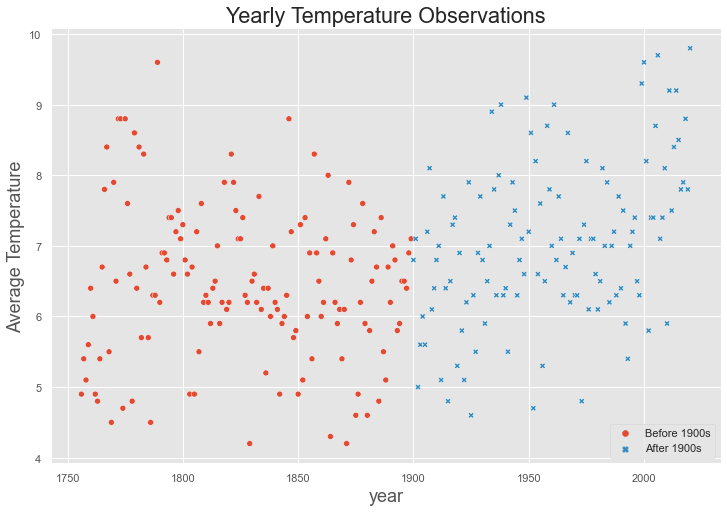

In [18]:
axs = sns.scatterplot(data=df, x=df.index, y='yearly_mean',hue='Epoc', style='Epoc')
axs.set_ylabel('Average Temperature')
axs.set_title('Yearly Temperature Observations')
axs.legend(loc='lower right');

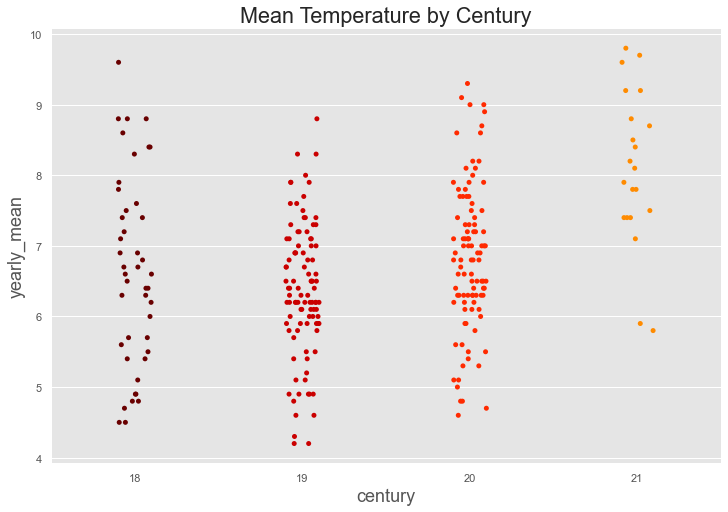

In [19]:
with sns.color_palette('hot'):
  axs = sns.stripplot(data=df, x='century', y='yearly_mean')
  axs.set_title('Mean Temperature by Century');

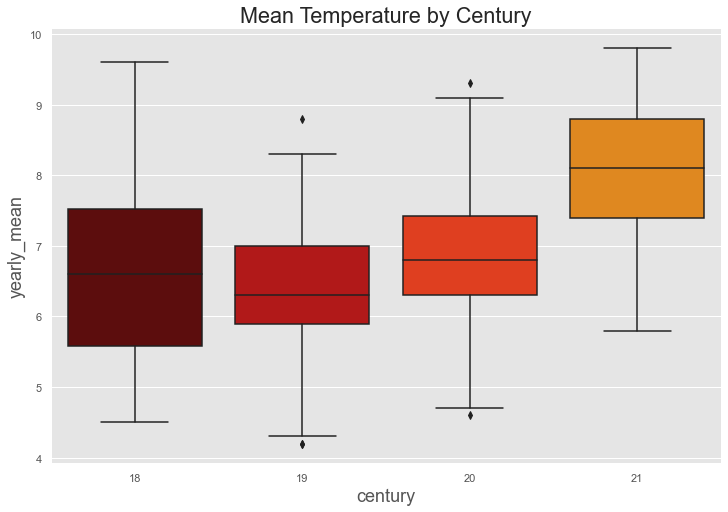

In [20]:
with sns.color_palette('hot'):
  axs = sns.boxplot(data=df, x='century', y='yearly_mean')
  axs.set_title('Mean Temperature by Century');

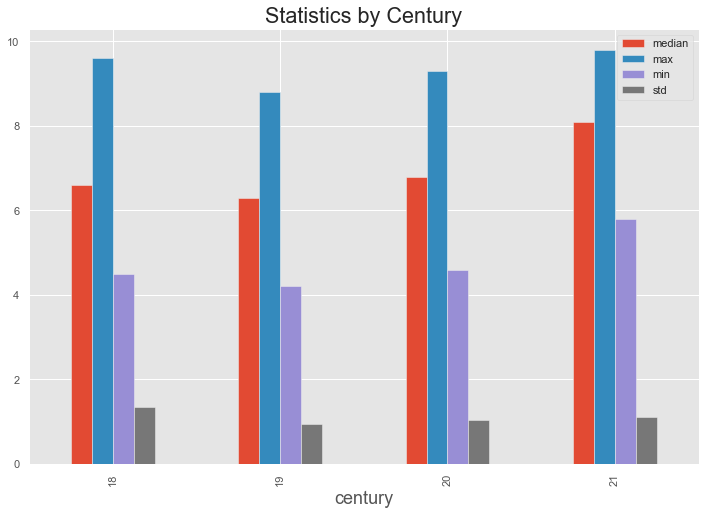

In [21]:
df.groupby('century')['yearly_mean'].agg(['median','max','min','std']).plot(kind='bar').set_title('Statistics by Century');

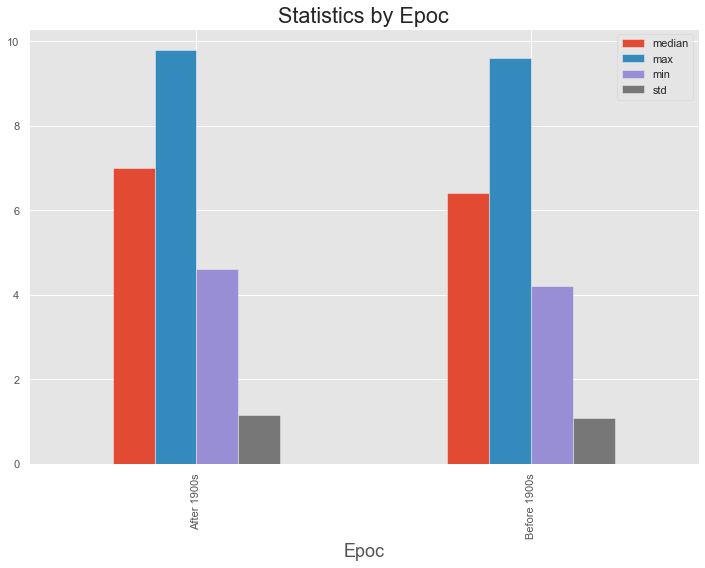

In [23]:
df.groupby('Epoc')['yearly_mean'].agg(['median','max','min','std']).plot(kind='bar').set_title('Statistics by Epoc');

In [24]:
before_1900s = df.loc[df['Epoc']=='Before 1900s']['yearly_mean']
after_1900s = df.loc[df['Epoc']=='After 1900s']['yearly_mean']

In [25]:
real_diff = np.mean(before_1900s) - np.mean(after_1900s)
print('Real Mean Difference:', abs(round(real_diff,3)),'C°')

Real Mean Difference: 0.6 C°


In [28]:
def permuted_id_samples(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    permuted_sample1 = permuted_data[:len(data1)]
    permuted_sample2 = permuted_data[len(data1):]
    return permuted_sample1 , permuted_sample2 

In [31]:
def sample_replicates(data_1, data_2, function, size=1):
    permuted_replicates= np.empty(size)

    for i in range(size):
        perm_sample1, perm_sample2 = permuted_id_samples(data_1, data_2)
        permuted_replicates[i] = function(perm_sample1, perm_sample2)

    return permuted_replicates

In [32]:
def means_diff(data_1, data_2):
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

In [33]:
n_bootstrap = 1000000

In [34]:
replicates = sample_replicates(before_1900s, after_1900s, means_diff, n_bootstrap)

In [35]:
prob = np.sum(replicates <= real_diff) / len(replicates)
print('The p-value for test statistic of',real_diff ,'is',round(prob,4))

The p-value for test statistic of -0.6003787878787872 is 0.0


In [36]:
confidence_interval = np.percentile(replicates, [2.7,97.5])

C:\Users\GABRIEL\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


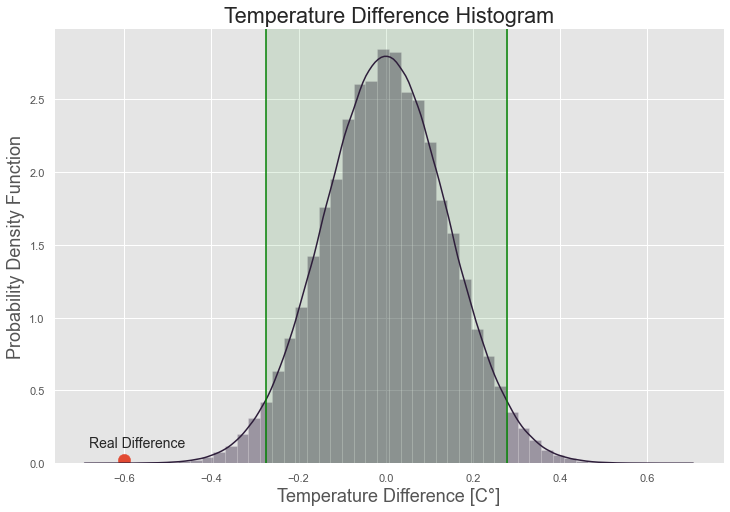

In [37]:
axs  = sns.distplot(replicates, color=palette[0])
axs.axvline(confidence_interval[0], color = 'green')
axs.axvline(confidence_interval[1], color = 'green')
axs.axvspan(confidence_interval[0],confidence_interval[1],color='green', alpha=0.1)
axs.scatter(x = real_diff, y = 0.025, s=150)
axs.text(real_diff-(0.08),  0.11,"Real Difference", fontsize=14)
axs.set_ylabel('Probability Density Function')
axs.set_xlabel('Temperature Difference [C°]')
axs.set_title('Temperature Difference Histogram');

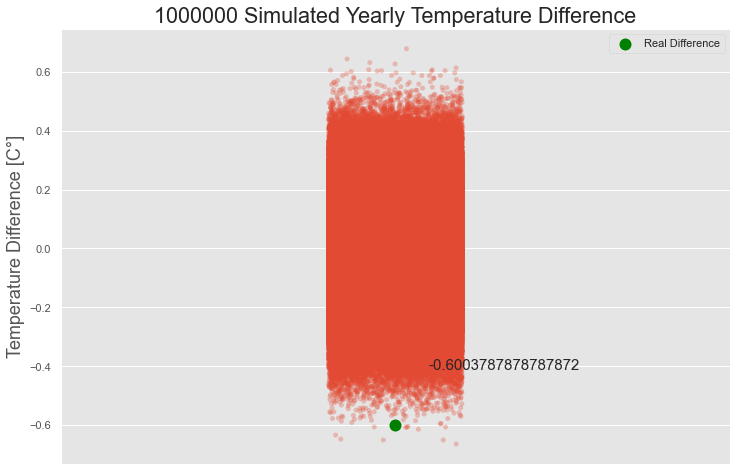

In [38]:
axs = sns.stripplot(y=replicates, alpha=0.3)
axs = sns.swarmplot(y= np.array([real_diff]), color= 'green', size=12, label='Real Difference')
axs.legend(loc='upper right')
axs.set_ylabel('Temperature Difference [C°]')
axs.set_title((str(n_bootstrap) + ' Simulated Yearly Temperature Difference'))
axs.annotate(str(real_diff), xy=(0.05,-0.41));